[View in Colaboratory](https://colab.research.google.com/github/agerk/google_ml_crash_course/blob/master/Cat_vs_Dog_image_classification_Part2.ipynb)

<h2> Reducing Model Overfitting</h2>

**Objective: ** Improve accuracy, reduce overfitting, by employing


1.   Data augmentation: artificially boosting diversity and number of training example
2.   Dropout regularization: randomly turn off neuron during training 

Accomplish the above objectives involves the folowing steps

1.   Make random transformation of training images and explore how data agumentation works
2.   Add data agumentation to data preprocessing pipeline
1.   Add drop out to convnet
2.   Retrain model from Part1 and re-evaluate loss and accuracy





<h3> Explore Data Augmentation</h3>

- Random transformation will help reduce overfitting by making sure that the **model will never see the exact same image twice**
- This can be done by configuring a number of transformation on the images read by `ImageDataGenerator` instannce from Keras 

In [0]:
# Load ImageDataGenerator from Keras
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range = 40,    # a value in degrees(0-180), a range to randomly rotate pictures 
    width_shift_range = 0.2,    # a range, as a fraction of total width to randomly translate horizontally
    height_shift_range = 0.2,   # a range, as a fraction of total height to randomly translate vertically
    shear_range = 0.2,    # for randomly applying shearing transformation 
    zoom_range = 0.2,    # for randomly zooming inside pictures
    horizontal_flip = True,   # for randomly flipping half of the images horizontally
    fill_mode = 'nearest')    # for filling newly created pixels which can appear after a rotation or a width/height shift

In [4]:
# Load sample data
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O \
   /tmp/cats_and_dogs_filtered.zip

--2018-05-30 23:44:09--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 2607:f8b0:4001:c14::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   127MB/s    in 0.5s    

2018-05-30 23:44:10 (127 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
# Create training and validation folders
import os
import zipfile

# Unzip files
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Create training and validation dir
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat and dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validatio cat and dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Get filename from training examples
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

<h4> Apply `datagen` transformation to a cat image from the training set to produce 5 random variants</h4>

Original training image in array format [[[ 35.  25.  16.]
  [ 22.  12.   3.]
  [ 12.   5.   0.]
  ...
  [ 14.  16.  15.]
  [ 74.  77.  68.]
  [ 94.  95.  90.]]

 [[ 29.  19.  10.]
  [ 22.  13.   6.]
  [ 14.   7.   1.]
  ...
  [ 15.  17.  16.]
  [ 74.  77.  68.]
  [ 95.  96.  91.]]

 [[ 15.   6.   0.]
  [ 20.  13.   7.]
  [ 15.  10.   6.]
  ...
  [ 22.  24.  23.]
  [ 79.  82.  73.]
  [ 96.  97.  92.]]

 ...

 [[ 94.  88.  72.]
  [ 96.  89.  71.]
  [ 99.  91.  72.]
  ...
  [ 82.  72.  62.]
  [ 69.  59.  49.]
  [ 73.  67.  55.]]

 [[100.  94.  78.]
  [ 92.  85.  67.]
  [ 96.  88.  69.]
  ...
  [ 77.  67.  57.]
  [ 72.  62.  52.]
  [ 75.  69.  57.]]

 [[ 99.  93.  77.]
  [ 94.  87.  69.]
  [ 94.  86.  67.]
  ...
  [ 79.  69.  59.]
  [ 78.  68.  58.]
  [ 67.  61.  49.]]]


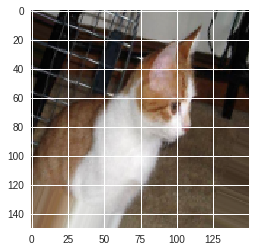

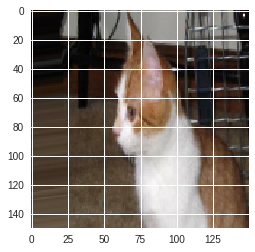

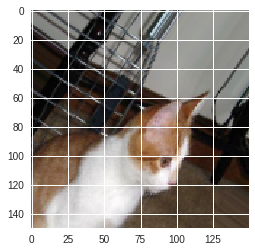

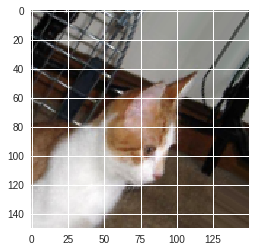

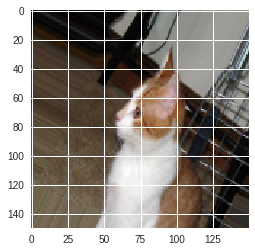

In [14]:
%matplotlib inline

import matplotlib.pylab as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import array_to_img, img_to_array, load_img

img_path = os.path.join(train_cats_dir, train_cat_fnames[2])
img = load_img(img_path, target_size=(150, 150))    # PIL image
x = img_to_array(img)    # Numpy array with shape (150, 150, 3)
print("Original training image in array format", x)
x = x.reshape((1,) + x.shape)    # Numpy array with shape (1, 150, 150, 3)

# Use .flow() command to generate batches of randomly transformed images
# It will loop indefinetly, so we need to 'break' the loop after 5 image transformation
i = 0
for batch in datagen.flow(x, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(array_to_img(batch[0]))    # conver x to image 
  i += 1
  if i % 5 == 0:
    break

<h2>Add Data Agumentation to the Preprocessing Step</h2>

Apply data agumentatio to training dataset

In [23]:
# Adding rescae, rotation_range, width_shift_range, height_shift_range, 
# shear_range, zoom_range, and horizontal flip to ImageDataGenerator instance
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest')

# Note that the validation data should not be augmented
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,    # source dir for training images
    target_size=(150, 150),    # all images will be rescaled to 150x150 
    batch_size=20,
    # since we se binary_crossentropy loss, we need binary labels
    class_mode = 'binary')

# Flow validation images in batched of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


<h2>Adding Dropout Regularization</h2>

Reconfigure the convnet architecture from Part1 to add some dropout, right before the final classification layer:

In [0]:
from keras.models import Model
from keras import layers
from keras.optimizers import RMSprop
from keras import backend as K

import tensorflow as tf

In [0]:
# Configure the TF backend seession and add GPU option
tf_config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(allow_growth=True))
K.set_session(tf.Session(config=tf_config))

# Input image feature map is 150x150x3: 150x150 for the image pixels, and 3 for 
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPool2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPool2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor
x = layers.Flatten()(x)

# Create a fully connected layer with reLu activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a sncel node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile model
model = Model(img_input, output)
model.compile(loss='binary_crossentropy',
             optimizer=RMSprop(lr=0.001),
             metrics=['acc'])

<h2>Retrain the Model</h2>

In [21]:
# Summarize network architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 64)        0         
__________

In [31]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch = 100,    # steps[100] x batch_size[20]
    epochs=60,    # Pass throught the dataset 30 times
    validation_data = validation_generator,
    validation_steps = 50,
    verbose = 2)

Epoch 1/60
 - 21s - loss: 0.5211 - acc: 0.7475 - val_loss: 0.4966 - val_acc: 0.7440
Epoch 2/60
 - 19s - loss: 0.5327 - acc: 0.7310 - val_loss: 0.5486 - val_acc: 0.7170
Epoch 3/60
 - 18s - loss: 0.5384 - acc: 0.7360 - val_loss: 0.5375 - val_acc: 0.7390
Epoch 4/60
 - 18s - loss: 0.5215 - acc: 0.7330 - val_loss: 0.5057 - val_acc: 0.7690
Epoch 5/60
 - 19s - loss: 0.5245 - acc: 0.7485 - val_loss: 0.5170 - val_acc: 0.7500
Epoch 6/60
 - 19s - loss: 0.5266 - acc: 0.7490 - val_loss: 0.4536 - val_acc: 0.7890
Epoch 7/60
 - 19s - loss: 0.5217 - acc: 0.7310 - val_loss: 0.6315 - val_acc: 0.6900
Epoch 8/60
 - 19s - loss: 0.5204 - acc: 0.7505 - val_loss: 0.4871 - val_acc: 0.7730
Epoch 9/60
 - 19s - loss: 0.4921 - acc: 0.7575 - val_loss: 0.4855 - val_acc: 0.7870
Epoch 10/60
 - 18s - loss: 0.5231 - acc: 0.7500 - val_loss: 0.4732 - val_acc: 0.7720
Epoch 11/60
 - 18s - loss: 0.5055 - acc: 0.7550 - val_loss: 0.5117 - val_acc: 0.7480
Epoch 12/60
 - 18s - loss: 0.5053 - acc: 0.7475 - val_loss: 0.5452 - val_a

Epoch 35/60
 - 19s - loss: 0.4887 - acc: 0.7710 - val_loss: 0.4346 - val_acc: 0.7970
Epoch 36/60
 - 19s - loss: 0.4866 - acc: 0.7740 - val_loss: 0.5350 - val_acc: 0.7780
Epoch 37/60
 - 19s - loss: 0.4935 - acc: 0.7810 - val_loss: 0.6155 - val_acc: 0.7580
Epoch 38/60
 - 19s - loss: 0.4949 - acc: 0.7685 - val_loss: 0.4742 - val_acc: 0.7830
Epoch 39/60
 - 20s - loss: 0.4962 - acc: 0.7630 - val_loss: 0.5443 - val_acc: 0.7420
Epoch 40/60
 - 20s - loss: 0.4922 - acc: 0.7650 - val_loss: 0.4863 - val_acc: 0.7980
Epoch 41/60
 - 20s - loss: 0.4788 - acc: 0.7825 - val_loss: 0.5322 - val_acc: 0.7750
Epoch 42/60
 - 20s - loss: 0.4847 - acc: 0.7825 - val_loss: 0.4760 - val_acc: 0.7800
Epoch 43/60
 - 20s - loss: 0.4838 - acc: 0.7770 - val_loss: 0.4166 - val_acc: 0.8250
Epoch 44/60
 - 20s - loss: 0.4820 - acc: 0.7775 - val_loss: 0.5293 - val_acc: 0.7680
Epoch 45/60
 - 20s - loss: 0.4763 - acc: 0.7775 - val_loss: 0.4311 - val_acc: 0.8180
Epoch 46/60
 - 20s - loss: 0.4928 - acc: 0.7690 - val_loss: 0.481

<h2>Evaluate the Results</h2>

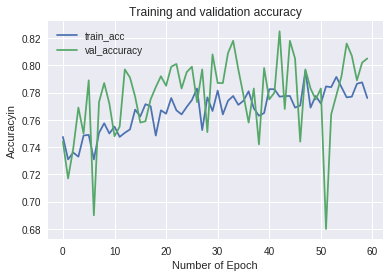

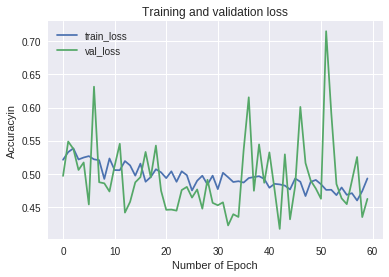

In [37]:
# Retrieve a list of accuracy results on training and test dataset
# for each training epoch
acc = history.history['acc']
# print(acc)
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training ans test dataset
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Visualize training and validation accurcy per epoch
plt.plot(epochs, acc, label='train_acc')
plt.plot(epochs, val_acc, label='val_accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracyin')
plt.legend()

plt.figure()

# Plot loss
plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Training and validation loss')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracyin')
plt.legend()

plt.show()

Conclusion: The model no longer overfitting to the trainig dataset-- it doenst memorize. Increasing the epochs from 30 to 60 increase the model accracy from 77% to 80

*This notebook is based on Google's ML Crash Course Practica*